In [1]:
import torch
import numpy as np
import joblib
import pandas as pd
from tst_model import TST  


In [2]:

# === Konfigurasi Model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TST(c_in=4, c_out=5*4, seq_len=12).to(device)
model.load_state_dict(torch.load("tst_ohlc_model.pt", map_location=device))
model.eval()

TST(
  (W_P): Linear(in_features=4, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (encoder): _TSTEncoder(
    (layers): ModuleList(
      (0-2): 3 x _TSTEncoderLayer(
        (self_attn): _MultiHeadAttention(
          (W_Q): Linear(in_features=128, out_features=128, bias=False)
          (W_K): Linear(in_features=128, out_features=128, bias=False)
          (W_V): Linear(in_features=128, out_features=128, bias=False)
          (W_O): Linear(in_features=128, out_features=128, bias=False)
          (attention): _ScaledDotProductAttention()
        )
        (dropout_attn): Dropout(p=0.1, inplace=False)
        (batchnorm_attn): Sequential(
          (0): Transpose()
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Transpose()
        )
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, i

In [3]:
# === Load Scaler ===
scaler = joblib.load("scalerTST.save")


In [4]:
# === Input Data OHLC (12 timestep) ===
input_data = [
    [0.91769, 0.91796, 0.91766, 0.91787],
    [0.91789, 0.91833, 0.91789, 0.91828],
    [0.91827, 0.91849, 0.91801, 0.91814],
    [0.91815, 0.91818, 0.91799, 0.91803],
    [0.91806, 0.91831, 0.91805, 0.91810],
    [0.91811, 0.91822, 0.91789, 0.91810],
    [0.91808, 0.91835, 0.91808, 0.91824],
    [0.91824, 0.91837, 0.91815, 0.91816],
    [0.91814, 0.91828, 0.91801, 0.91825],
    [0.91825, 0.91869, 0.91819, 0.91866],
    [0.91864, 0.91867, 0.91843, 0.91845],
    [0.91847, 0.91856, 0.91838, 0.91852],
]
input_array = np.array(input_data, dtype=np.float32)

In [5]:
# === Normalisasi Input ===
input_scaled = scaler.transform(input_array)

d:\abel_prediksi\TST_MultiVariant_MultiStepPrediction\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [6]:
# === Format ke Tensor (1, 4, 12)
input_tensor = torch.tensor(input_scaled, dtype=torch.float32).unsqueeze(0).permute(0, 2, 1).to(device)


In [7]:
# === Prediksi
with torch.no_grad():
    output = model(input_tensor).view(-1, 5, 4).cpu().numpy()[0]


In [8]:
# Format input untuk model
input_tensor = torch.tensor(input_scaled, dtype=torch.float32).unsqueeze(0).permute(0, 2, 1).to(device)


In [9]:
# === Kembalikan ke Skala Asli
output_inverse = scaler.inverse_transform(output)

In [11]:

# === Tampilkan Hasil
df_pred = pd.DataFrame(output_inverse, columns=["Open", "High", "Low", "Close"])
print("\nPrediksi OHLC untuk 5 bar ke depan:")
print(df_pred.round(6))


Prediksi OHLC untuk 5 bar ke depan:
       Open      High       Low     Close
0  0.919378  0.919576  0.919180  0.919372
1  0.919375  0.919536  0.919155  0.919316
2  0.919349  0.919533  0.919147  0.919299
3  0.919236  0.919455  0.919109  0.919347
4  0.919339  0.919594  0.919163  0.919384


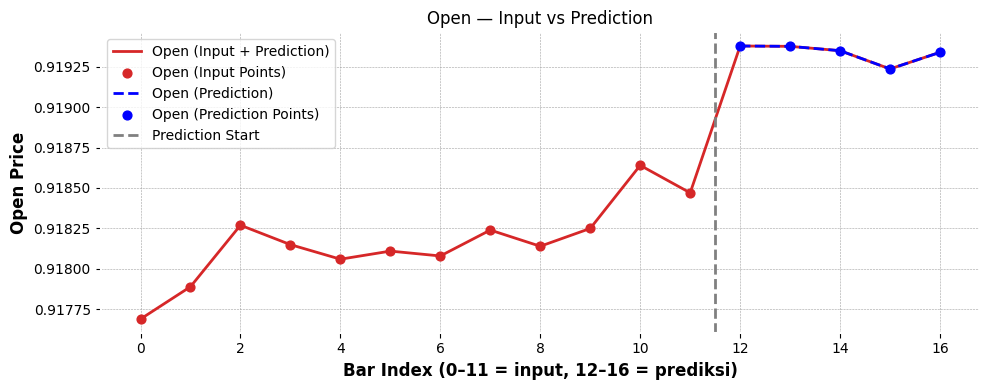

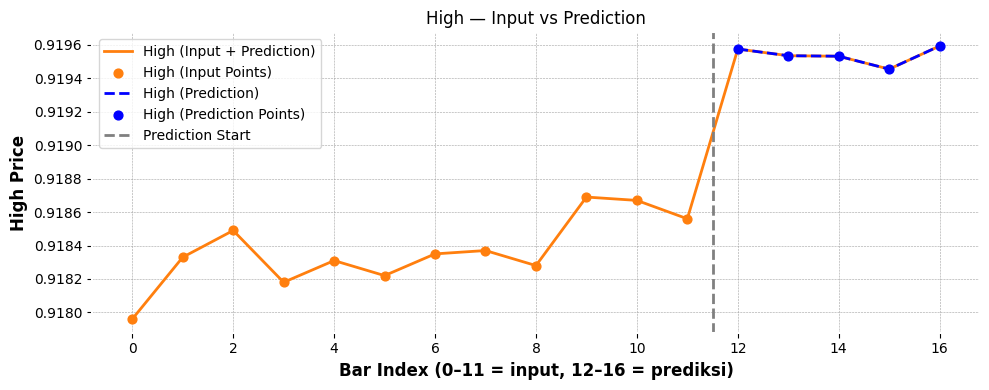

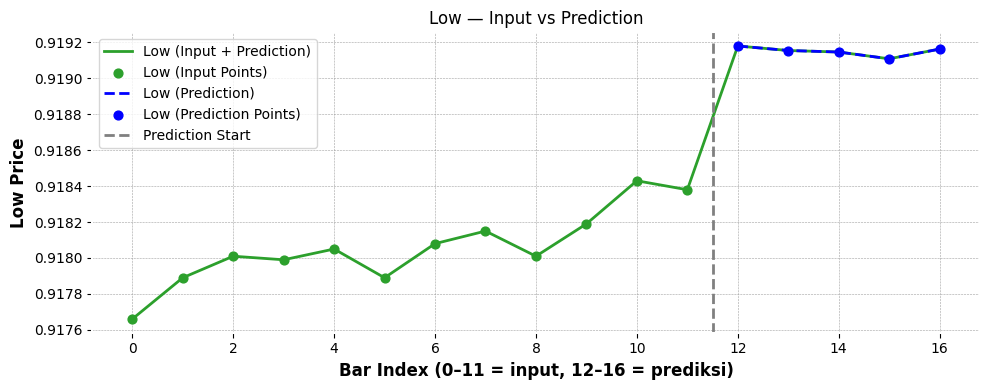

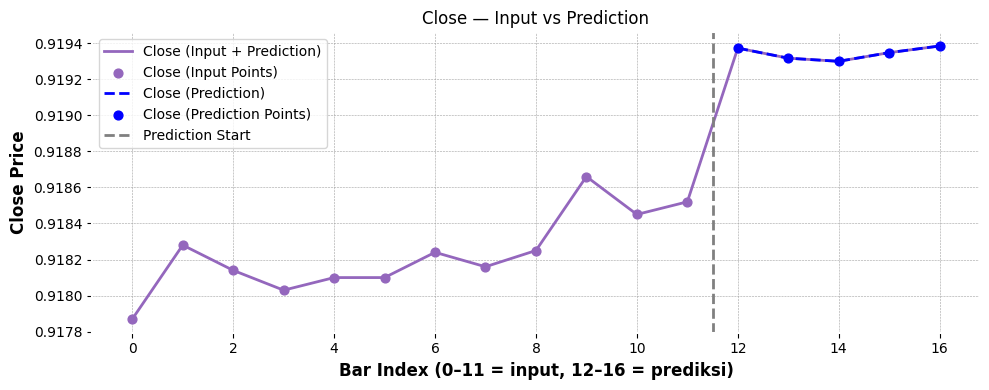

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Asumsi:
# - ohlc_input = input manual 12 bar (shape: [12, 4])
# - prediction = output_inverse (hasil prediksi, shape: [5, 4])

feature_names = ['Open', 'High', 'Low', 'Close']
input_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:purple']
prediction_color = 'blue'  # Warna untuk prediksi

for i, name in enumerate(feature_names):
    full_series = np.concatenate([input_array[:, i], prediction[:, i]])  # Gabungkan input dan prediksi
    plt.figure(figsize=(10, 4))

    # Plot full line
    plt.plot(range(len(full_series)), full_series, label=f'{name} (Input + Prediction)', color=input_colors[i])

    # Titik input
    plt.scatter(range(12), input_array[:, i], color=input_colors[i], s=40, label=f'{name} (Input Points)', zorder=3)

    # Garis & titik prediksi
    plt.plot(range(12, len(full_series)), prediction[:, i], color=prediction_color, label=f'{name} (Prediction)', linestyle='--')
    plt.scatter(range(12, len(full_series)), prediction[:, i], color=prediction_color, s=40, label=f'{name} (Prediction Points)', zorder=3)

    # Garis pemisah input/prediksi
    plt.axvline(x=11.5, color='gray', linestyle='--', label='Prediction Start')

    # Styling
    plt.title(f'{name} — Input vs Prediction')
    plt.xlabel('Bar Index (0–11 = input, 12–16 = prediksi)')
    plt.ylabel(f'{name} Price')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


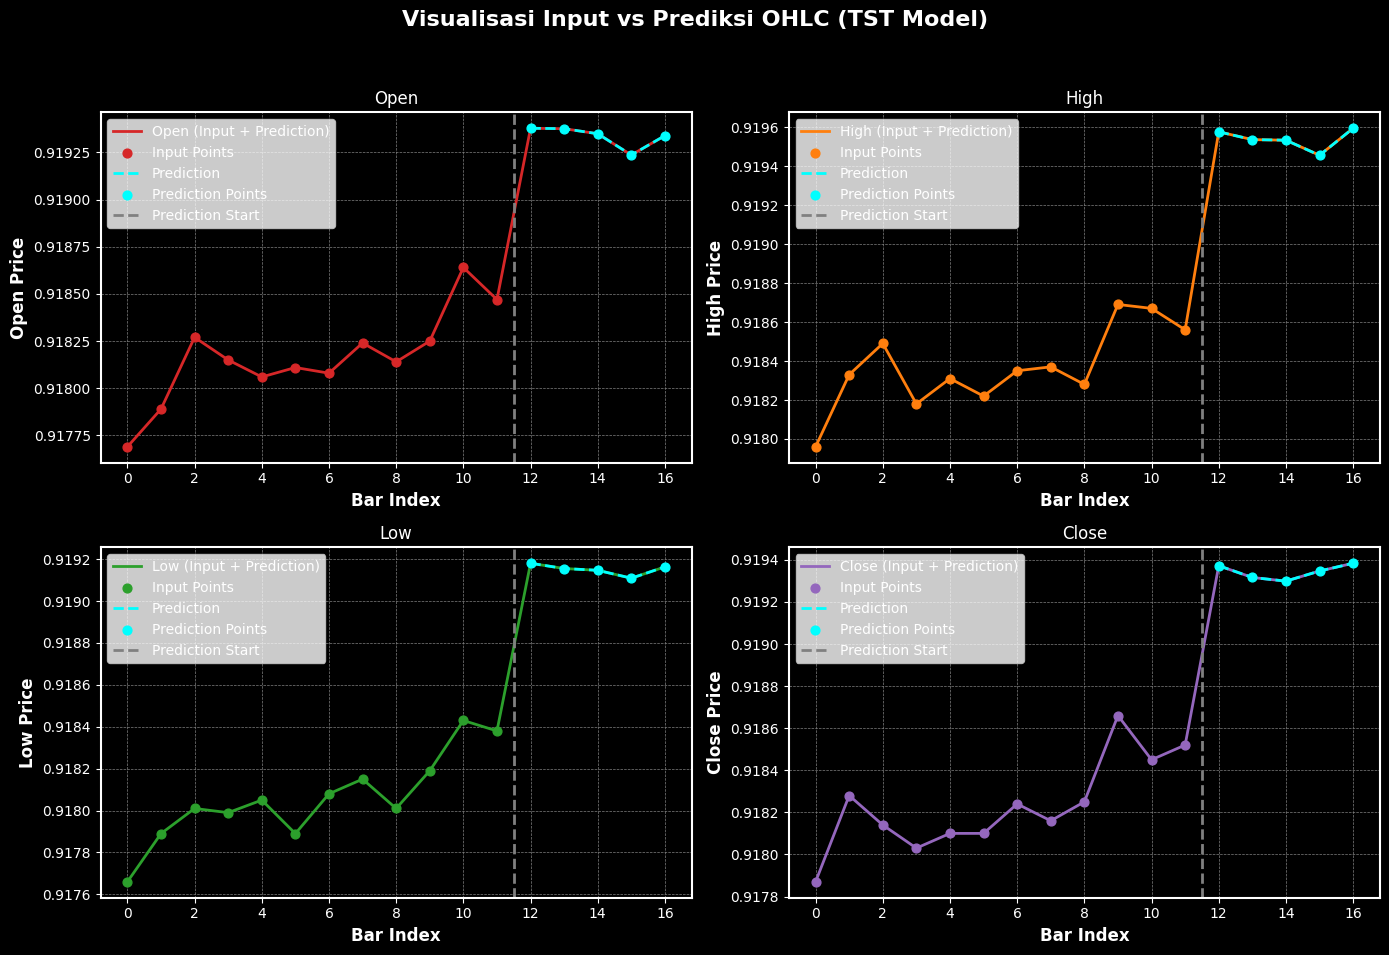

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Asumsi:
# input_array.shape = (12, 4)
# prediction.shape = (5, 4)

feature_names = ['Open', 'High', 'Low', 'Close']
input_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:purple']
prediction_color = 'cyan'  # Bisa diganti sesuai selera

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.patch.set_facecolor('black')  # Warna latar belakang figure
fig.suptitle('Visualisasi Input vs Prediksi OHLC (TST Model)', fontsize=16, color='white')

# Susunan subplot: Open kiri atas, High kanan atas, Low kiri bawah, Close kanan bawah
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

for i, name in enumerate(feature_names):
    row, col = positions[i]
    full_series = np.concatenate([input_array[:, i], prediction[:, i]])
    ax = axs[row][col]

    ax.set_facecolor('black')  # Latar belakang subplot
    ax.plot(range(len(full_series)), full_series, label=f'{name} (Input + Prediction)', color=input_colors[i])
    ax.scatter(range(12), input_array[:, i], color=input_colors[i], s=40, label='Input Points', zorder=3)
    ax.plot(range(12, len(full_series)), prediction[:, i], color=prediction_color, linestyle='--', label='Prediction')
    ax.scatter(range(12, len(full_series)), prediction[:, i], color=prediction_color, s=40, label='Prediction Points', zorder=3)
    ax.axvline(x=11.5, color='gray', linestyle='--', label='Prediction Start')

    # Styling
    ax.set_title(f'{name}', color='white')
    ax.set_xlabel('Bar Index', color='white')
    ax.set_ylabel(f'{name} Price', color='white')
    ax.tick_params(colors='white')
    ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

    # Putihkan legenda
    legend = ax.legend()
    for text in legend.get_texts():
        text.set_color("white")

# Layout dan padding
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
